In [41]:
import datetime
import pandas as pd
import geopandas as gpd
from dataclasses import dataclass
import uuid

from shapely.geometry import MultiPolygon, Polygon

from matplotlib import pyplot as plt
import numpy as np

import scipy

In [2]:
df = pd.read_pickle('./Maria2019_simulation_new.pkl')

In [126]:
geom1 = df[df['windspeed'] == 19].iloc[40]['geometry'][0]
geom2 = df[df['windspeed'] == 19].iloc[10]['geometry'][0]

In [98]:
def eqinterp(vertices, dnumber):
    vertices = np.array(vertices)
    step_len = np.sqrt(np.sum(np.diff(vertices, 1, 0)**2, 1)) # length of each side
    step_len = np.append([0], step_len)
    cumulative_len = np.cumsum(step_len)
    interpolation_loc = np.linspace(0, cumulative_len[-1], dnumber)
    X = np.interp(interpolation_loc, cumulative_len, vertices[:,0])
    Y = np.interp(interpolation_loc, cumulative_len, vertices[:,1])

    return list(zip(X,Y))

In [96]:
x,y = df.iloc[0]['geometry'].exterior.coords.xy
coords = []
for xx,yy in zip(list(x),list(y)):
    coords.append(np.array((xx,yy)))

coords = np.array(coords)

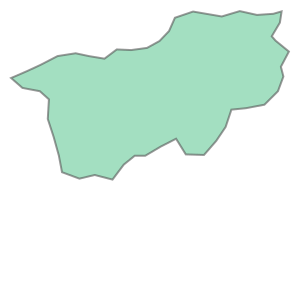

In [103]:
inter_coords = eqinterp(coords, 50)
Polygon(shell=inter_coords)

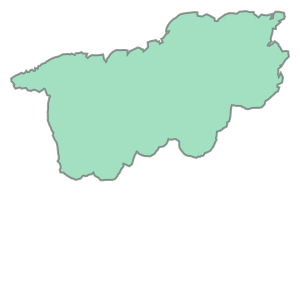

In [95]:
Polygon(shell=vertices)

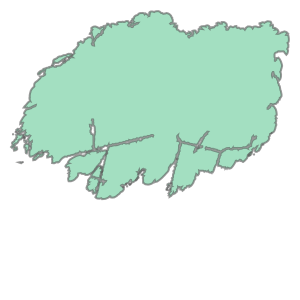

In [142]:
compareidx = '714f0cf8d475462a97c651642a3d2525'

df[(df['windspeed'] == 19) & (df['compareidx']==compareidx)].iloc[9]['geometry']

In [66]:
x = []
y = []
for coord in geom[0].exterior.coords:
    x.append(coord[0])
    y.append(coord[1])

In [72]:
dist = []
for ix in range(len(x)-1):
    x1 = x[ix+1]
    x0 = x[ix]
    
    y1 = y[ix+1]
    y0 = y[ix]
    
    dist.append(np.sqrt((x1-x0)**2 + (y1-y0)**2))

In [100]:
filter = np.ones(20)
xnew = np.convolve(x, filter, mode='valid')/len(filter)
ynew = np.convolve(y, filter, mode='valid')/len(filter)

In [115]:
geom_skipped = Polygon(shell=geom[0].exterior.coords[::10])

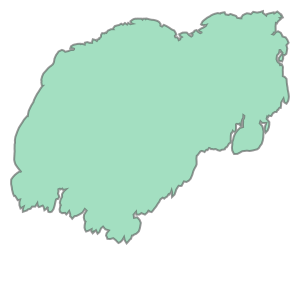

In [116]:
geom[0]

In [119]:
def reposition_coords(polygon, Ncoords):
    # Skips every len(coords)/Ncoords
    coords = polygon.exterior.coords
    if Ncoords > len(coords):
        print('Not yet defined')
        return None
    
    delta = len(coords)/Ncoords
    new_coords = []
    for ix in range(Ncoords):
        new_coords.append(coords[int(delta*ix)])
        
    return Polygon(shell=new_coords)

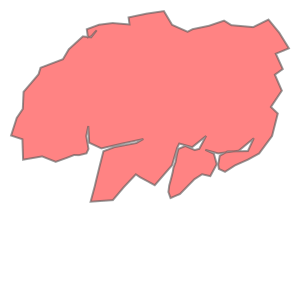

In [150]:
reposition_coords(df[(df['windspeed'] == 19) & (df['compareidx']==compareidx)].iloc[9]['geometry'][0], 100)

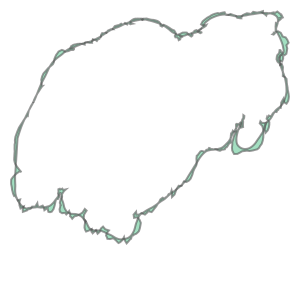

In [106]:
geom[0].union(Polygon(shell = zip(xnew,ynew))) - geom[0].intersection(Polygon(shell = zip(xnew,ynew)))

In [99]:
Polygon(shell = zip(xnew,ynew)).exterior.coords[0]

(-41726918.99999999, 30065693.000000026)